# AttentiveFP

The AttentiveFP is introduced in 2020, a graph-based neural network framework that captures the atomic local environment by propagating node information from neighbouring nodes to distant ones but also enables nonlocal effects at the intramolecular level by employing a graph attention mechanism. Their findings demonstrate that the AttentiveFP can effectively extract nonlocal intramolecular interactions that are often challenging to model using traditional graph-based representations. The notion of incorporating an attention mechanism into graph-based models aims to derive a context vector for the target node by emphasizing its neighboring nodes and local environment. Specifically, the Attentive FP molecular representation approach employs a dual-stack mechanism of attentive layers to extract information from the molecular graph. The first stack is responsible for atom embedding, while the second is for full-molecule embedding.

The attention mechanism is incorporated into the individual-atom and full-molecule embedding processes. To create the molecule embedding, all atom embeddings are aggregated through a super virtual node, interconnecting all atoms within the molecule. In terms of atom embedding, a graph attention mechanism is introduced at each layer to assimilate information from the surrounding neighbourhoods.

Based on the multi-head attention mechanism from GAT, the attention context $n'$ is combined with the current state vector of the target atom and fed into a recurrent gated unit (GRU). The GRU recurrent network unit facilitates efficient transmission of information to the surrounding nodes during the update iterations.

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
import torch
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="AttentiveFP",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [5]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [6]:
from model.dgl.AttentiveFP import AttentiveFP

AbstractModel.set_seed(2387)

k_pred_tst1 = []

for trn, val in zip(trn_sets, val_sets):
    model = AttentiveFP(
        task_type="regression",
        # AttentiveFP Configuration
        n_tasks=1,
        node_feat_size=featurizer.get_node_feat_size(),
        edge_feat_size=featurizer.get_edge_feat_size(),
        graph_feat_size=200,
        num_layers=5,
        num_timesteps=3,
        dropout=0.3971992048727058,
        # General DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.00289,
        batch_size=4096
    )
    model.fit(trn, val=val, epochs=400, min_epoch=250, early_stop=20)
    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


 74%|███████▍  | 295/400 [00:39<00:14,  7.49it/s, loss: 0.234 rmse: 1.115]


[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


 78%|███████▊  | 313/400 [00:40<00:11,  7.71it/s, loss: 0.269 rmse: 0.687]


[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


100%|██████████| 400/400 [00:45<00:00,  8.74it/s, loss: 0.256 rmse: 0.712]


[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


 71%|███████   | 284/400 [00:30<00:12,  9.39it/s, loss: 0.253 rmse: 0.764]


[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


100%|██████████| 400/400 [00:42<00:00,  9.42it/s, loss: 0.241 rmse: 0.748]


In [7]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [8]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 0.882411650691491
TST : R^2 0.5773163666680088


Text(0.5, 1.0, '2008 Solubility Challenge Test Set (AttentiveFP)\nRMSE: 0.882, $R^2$: 0.577')

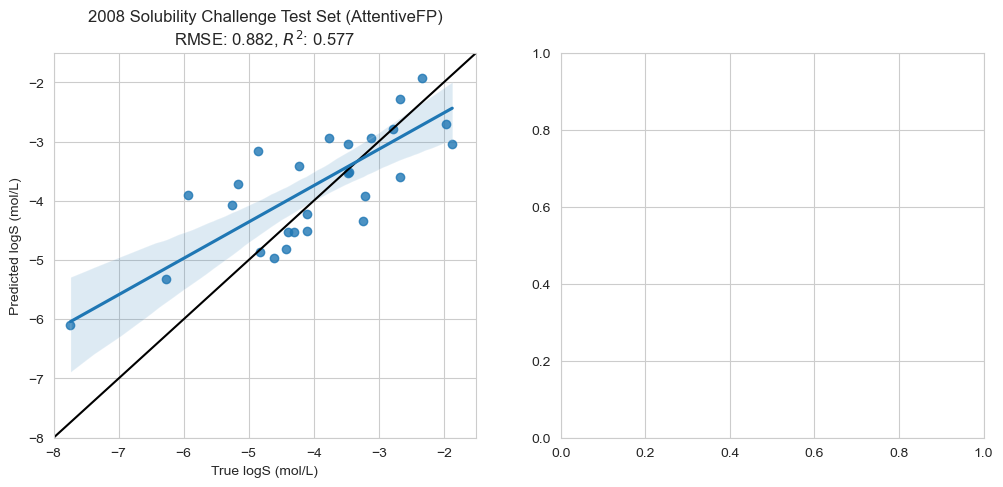

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

model_name = "AttentiveFP"
min_ax1, max_ax1 = -8, -1.5

fig, (ax1, _) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)

ax1.set_title(f"2008 Solubility Challenge Test Set ({model_name})\n"
              f"RMSE: {mean_squared_error(TST.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST.y, pred_tst1):.3f}")